# Startup Funding Regression Project

In [21]:
!pip install fuzzywuzzy[speedup]

In [137]:
import pandas as pd
import numpy as np
import unicodedata
import codecs
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from fuzzywuzzy import process, fuzz
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### For this project I decided to use kaggle´s Indian Startup database due to its rawness and the feature engineering needed to make ML ready.

In [138]:
df = pd.read_csv('indian_startup.csv')
df.head()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
0,1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,"20,00,00,000",NaN
1,2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,"80,48,394",NaN
2,3,09/01/2020,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,"1,83,58,860",NaN
3,4,02/01/2020,https://www.wealthbucket.in/,FinTech,Online Investment,New Delhi,Vinod Khatumal,Pre-series A,"30,00,000",NaN
4,5,02/01/2020,Fashor,Fashion and Apparel,Embroiled Clothes For Women,Mumbai,Sprout Venture Partners,Seed Round,"18,00,000",NaN


In [139]:
df.loc[df['Investors Name'].str.contains('undisclosed', na=False, case=False), 'Investors Name']

69                                            Undisclosed
129                                           Undisclosed
253     Undisclosed Existing Investors As Well As The ...
425                                 Undisclosed Investors
432                                 Undisclosed Investors
                              ...                        
2883                                Undisclosed Investors
2922                                          Undisclosed
2976                                          Undisclosed
3008                                Undisclosed Investors
3026                                Undisclosed Investors
Name: Investors Name, Length: 146, dtype: object

### With a size of 30444 rows, it gives a decent sample size for a regression ML model. Another thing to note is all the 'object' type columns.

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Sr No              3044 non-null   int64 
 1   Date dd/mm/yyyy    3044 non-null   object
 2   Startup Name       3044 non-null   object
 3   Industry Vertical  2873 non-null   object
 4   SubVertical        2108 non-null   object
 5   City  Location     2864 non-null   object
 6   Investors Name     3020 non-null   object
 7   InvestmentnType    3040 non-null   object
 8   Amount in USD      2084 non-null   object
 9   Remarks            419 non-null    object
dtypes: int64(1), object(9)
memory usage: 237.9+ KB


### First thing I look for are the NAN percentages, I immediately spot a column that becomes useless for this project.

In [141]:
df.isna().sum() / len(df) * 100

Sr No                 0.000000
Date dd/mm/yyyy       0.000000
Startup Name          0.000000
Industry Vertical     5.617608
SubVertical          30.749014
City  Location        5.913272
Investors Name        0.788436
InvestmentnType       0.131406
Amount in USD        31.537451
Remarks              86.235217
dtype: float64

### Since there is no way of filling NANs and due to the nature of the column, I decide to drop it.

In [142]:
df = df.drop(columns='Remarks')

## I also drop null values in our 'Amount in USD' column since this will be our target, so we cant fill them.

In [143]:
df = df.dropna(subset='Amount in USD')

### Next thing I notice is that the 'Amount' column is of 'object' type, so I look into which classes are mixed there.

In [144]:
df['Amount in USD'].apply(type).value_counts()

Amount in USD
<class 'str'>    2084
Name: count, dtype: int64

### If we look into the column, we notice that the numbers are formatted the Indian way, so Python takes them as strings.

In [145]:
df['Amount in USD'].head(10)

0    20,00,00,000
1       80,48,394
2     1,83,58,860
3       30,00,000
4       18,00,000
5       90,00,000
6    15,00,00,000
7       60,00,000
8     7,00,00,000
9     5,00,00,000
Name: Amount in USD, dtype: object

### I decide to write a function that cleans the strings and converts them to float type.

In [146]:
def clean_amount(value):
    if isinstance(value, str):
        try:
            return float(value.replace(',', ''))
        except ValueError:
            return np.nan
    elif isinstance(value, (int, float)):
        return value
    else:
        return np.nan
    

df['Amount in USD'] = df['Amount in USD'].apply(clean_amount)

## Here I clean and standarize the date column to convert it from object to datetime and keep the Year as a feature.

In [147]:
df['Date dd/mm/yyyy'] = (
    df['Date dd/mm/yyyy']
    .astype(str)
    .str.encode('utf-8', 'ignore').str.decode('utf-8', 'ignore')  
    .str.replace(r'\\xc2\\xa0', '', regex=True) 
    .str.replace(r'\\\\xc2\\\\xa0', '', regex=True) 
    .str.replace('\xa0', '', regex=False)  
    .str.replace(r'\s+', '', regex=True)
    .str.replace(r'(\d{2}/\d{2})(\d{4})', r'\1/\2', regex=True)
    .str.replace(r'(\d{2}/\d{2})/(\d{3})$', r'\1/2\2', regex=True)
    .str.replace(r'(\d{2}/\d{2})\.(\d{4})', r'\1/\2', regex=True)
    .str.replace(r'//', '/', regex=True)
)

df['Year'] = pd.to_datetime(df['Date dd/mm/yyyy'], errors='coerce', dayfirst=True).dt.year

df[df['Year'].isna()]['Date dd/mm/yyyy'].head(10)

Series([], Name: Date dd/mm/yyyy, dtype: object)

### Here I hit one of the main stonewalls in this project, the SubVertical column is too inconsistent to be a feature, due to it being more of a 'business description' value rather than a categorical subvertical.

In [148]:
df['SubVertical'].head(20)

0                                   E-learning
1                    App based shuttle service
2        Retailer of baby and toddler products
3                            Online Investment
4                  Embroiled Clothes For Women
5     Open-market, freight management platform
6                Online Food Delivery Platform
7                                     Agritech
8                                   Automobile
9                      Satellite Communication
10            Logistics Services and Solutions
11                Food Solutions For Corporate
12    Online Meat And Seafood Ordering Startup
13               Non-Banking Financial Company
14               Experience Discovery Platform
15             Real money based gaming startup
16              Online Eyewear Shopping Portal
17      Business and customer engagement tools
18             Men's Health and Wellness brand
19                                   Elearning
Name: SubVertical, dtype: object

### That incosistency makes it so there are 1942 different values in a 3044 long database (FULL DF), 63,7% unique values. But there is potential here to create a valuable feature.

In [149]:
df['SubVertical'].nunique()

1315

### What I decide to go for is to create a new column, which will be my feature, and fill it with 'X' to mark the uncategorized ones.

In [150]:
df['Clean SubVertical'] = 'X'

### To handle the NANs here, due to it being a SubVertical, I decide to fill in with the business´s Vertical. 

In [151]:
df['SubVertical'] = df['SubVertical'].fillna(df['Industry Vertical'])

### And here comes the 'tedious' part, I´ll manually look at the database and recognize keywords and patterns so I can create my own subset of subverticals and recategorize the startups.

In [183]:
df.loc[(df['Clean SubVertical'] == 'X') & (df['SubVertical'].str.contains(r'agg', regex=True, case=False, na=False)), ['Startup Name','Industry Vertical','SubVertical','Clean SubVertical']].head(50)

,Startup Name,Industry Vertical,SubVertical,Clean SubVertical
258,Bizongo,Consumer Internet,Aggregator For Packaging Material,X
1042,Blackbuck,Logistics,Online freight aggregator,X
1288,Deyor Camps,Consumer Internet,Branded Camping location Aggregator,X
1922,American Vision,Consumer Internet,Optical Store Aggregator Platform,X
2140,BlackBuck,Online Freight Services Aggregator,Online Freight Services Aggregator,X
2210,BookMyBai,Domestic Help Aggregation platform,Domestic Help Aggregation platform,X
2837,PolicyBazaar,Online Policy Aggregator,Online Policy Aggregator,X


### After looking at the database, I noticed 2 scenarios:
1. A set of keywords, in which case I filter by that subset of words and replace with the new category.
2. Descriptions were there is no keyword, but the context itself gives away which category it falls into, in this case I manually recategorize each one using its index.

In [184]:
def classify(rows, label):
    df.loc[rows, 'Clean SubVertical'] = label

df.loc[df['SubVertical'].str.contains('ecommerce|e-commerce|commerce|retail', case=False, na=False), 'Clean SubVertical'] = 'Ecommerce'
classify([131,128,124,123,49,96,27,169,176,191,199,231,366,542,], 'Ecommerce')

df.loc[df['SubVertical'].str.contains('online mark|agg', case=False, na=False), 'Clean SubVertical'] = 'Online Marketplace'

df.loc[df['SubVertical'].str.contains(r'health|medic|doctor|clinic|hospitals?\b', regex=True, case=False, na=False), 'Clean SubVertical'] = 'Health Related Services'
classify([21,28,71,99,117,151,154,161,237,304,242,1871], 'Health Related Services')

df.loc[df['SubVertical'].str.contains('diagnos|probio|cancer', case=False, na=False),'Clean SubVertical'] = 'Diagnostics & Medical Testing'

df.loc[df['SubVertical'].str.contains('pharma', case=False, na=False), 'Clean SubVertical'] = 'Pharmacy'

# Here I first filter by 'food' and label all of them as 'Food Related Services'.Then if they include 'food delivery' or other, I recategorize as 'Grocery / Food Delivery' 
df.loc[df['SubVertical'].str.contains('beverage|meat|food|juice|dairy', case=False, na=False), 'Clean SubVertical'] = 'Food Related Services'
classify([6,11,12,56,59,66,53,126,130,1856,20,531],'Food Related Services')
df.loc[df['SubVertical'].str.contains('food delivery|food ordering|grocer|coffee', case=False, na=False), 'Clean SubVertical'] = 'Grocery / Food Delivery Services'
classify([132,190,181,249,2305,859,547], 'Grocery / Food Delivery Services')

df.loc[df['SubVertical'].str.contains(r'rick|rental car|vehicle rental|car rent|carpool|bike rent|taxi|bicycle|drivers|online car| cab |cab |cabs|(?=.*\bvehicle\b)(?=.*\bbooking\b)|ride sha', regex=True, case=False, na=False), 'Clean SubVertical'] = 'Transportation Rental Services'
classify([1,26,29,64,60,87,110,133,172,183,247,621,221,721,2198,2376,1569,1546,1481,1637,1130],'Transportation Rental Services')

df.loc[df['SubVertical'].str.contains(r'(?=.*\belectric\b)(?=.*\bmanufacturer\b)', regex=True, case=False, na=False), 'Clean SubVertical'] = 'Electric Vehicle Manufacturer'

classify([8,44,46,50,61,94,116,134,147,205,724,1023,2102,679,1258,2668,2642,2657,2216,2410,2576,1293,1751,628,2244,2193,2123],'Automotive Related Services')

classify([236,849,1180,1196,1492,2345,2530], 'Doorstep Delivery Services')

df.loc[df['SubVertical'].str.contains('logistic|supply chain|truck|cargo|warehous', case=False, na=False), 'Clean SubVertical'] = 'Logistic & Supply Chain Related Services'
classify([5,10,32,45,69,92,11,145,111,152,149,150,253], 'Logistic & Supply Chain Related Services')

df.loc[df['SubVertical'].str.contains('fitness|wellness| spa |lifestyle', case=False, na=False), 'Clean SubVertical'] = 'Fitness & Wellness Related Services'
classify([18,42,93,102,136,222,224,2098], 'Fitness & Wellness Related Services')

df.loc[df['SubVertical'].str.contains('baby', case=False, na=False), 'Clean SubVertical'] = 'Baby Supplies'
classify([2,159], 'Baby Supplies')

df.loc[df['SubVertical'].str.contains('fashion|linger|apparel', case=False, na=False), 'Clean SubVertical'] = 'Fashion Retail'
classify([4,72,105,113,1599], 'Fashion Retail')

df.loc[df['SubVertical'].str.contains('eyewear', case=False, na=False), 'Clean SubVertical'] = 'Eyewear Retail'
classify([16], 'Eyewear Retail')

df.loc[df['SubVertical'].str.contains(r'(?=.*\blearning\b)(?=.*\bplatform\b)', regex=True, case=False, na=False), 'Clean SubVertical'] = 'E-learning'
df.loc[df['SubVertical'].str.contains(r'(?=.*\blearning\b)(?=.*\bapp\b)', regex=True, case=False, na=False), 'Clean SubVertical'] = 'E-learning'
df.loc[df['SubVertical'].str.contains(r'(?=.*\bkids\b)(?=.*\blearning\b)', regex=True, case=False, na=False), 'Clean SubVertical'] = 'E-learning'
df.loc[df['SubVertical'].str.contains('online certi|elearning|e-learning|how-to', regex=True, case=False, na=False), 'Clean SubVertical'] = 'E-learning'

df.loc[df['SubVertical'].str.contains('tutor|coach|mentor', regex=True, case=False, na=False), 'Clean SubVertical'] = 'Coach & Tutoring Services'

df.loc[df['SubVertical'].str.contains('education|ed-tech|school|skill|study|edutech|e-tech', regex=True, case=False, na=False), 'Clean SubVertical'] = 'Education'
classify([30,38,67,137,57,2064,2028,1827,1682,854,418,412,406,384,269,2020,316,372,369,2524,715,1092,1574,1705,2243], 'Education')

df.loc[df['SubVertical'].str.contains('game|gaming', case=False, na=False), 'Clean SubVertical'] = 'Gaming'
classify([15,24,129,158], 'Gaming')

df.loc[df['SubVertical'].str.contains('agri-|agricult|farmer', case=False, na=False), 'Clean SubVertical'] = 'Agritech'
classify([7,22,81,95], 'Agritech')

df.loc[df['SubVertical'].str.contains('artificial int', case=False, regex=True, na=False), 'Clean SubVertical'] = 'AI Related'
df.loc[df['SubVertical'].str.contains(r'\bAI\b', case=False, regex=True, na=False), 'Clean SubVertical'] = 'AI Related'
classify([80,65,51,141,177,178,182,254], 'AI Related')

df.loc[df['SubVertical'].str.contains('wealth|invest|stock|trading|capital|bitcoin', case=False, na=False), 'Clean SubVertical'] = 'Investment/Wealth Management'
classify([98,55,47,3,188,220,250,246,238], 'Investment/Wealth Management')

df.loc[df['SubVertical'].str.contains('lending|loan|financ|payment|wallet', case=False, na=False), 'Clean SubVertical'] = 'Banking/Payments/Financial Services'
classify([78,77,103,86,85,13,23,54,31,35,36,162,163,173,175,184,225,251,257,1296,495,698,1210,2147], 'Banking/Payments/Financial Services')
classify([118,127,138,142,223,230,215,841,798,819], 'Non Banking Financial Services')

df.loc[df['SubVertical'].str.contains('credit|fraud|score|risk|fin-|finte', case=False, na=False), 'Clean SubVertical'] = 'Fintech / Credit Scoring / Risk Analysis'



df.loc[df['SubVertical'].str.contains('property|real estate|flat rental|residential rental|rental acco', case=False, na=False), 'Clean SubVertical'] = 'Real Estate'
classify([125,74], 'Real Estate')

df.loc[df['SubVertical'].str.contains('travel|hotel|trip|holiday|night|budget acc|hospitality', case=False, na=False), 'Clean SubVertical'] = 'Travel/Trip Related Services'
classify([121,101,170,743], 'Travel Related Services')
classify([146,97,75,2008,2350], 'Wine & Beer')

df.loc[df['SubVertical'].str.contains('marketing|advertising', case=False, na=False), 'Clean SubVertical'] = 'Marketing'
classify([107,37,], 'Marketing')

df.loc[df['SubVertical'].str.contains('robotic|robot', case=False, na=False), 'Clean SubVertical'] = 'Robotics'

df.loc[df['SubVertical'].str.contains('video|music|movie|tv', case=False, na=False), 'Clean SubVertical'] = 'Video Content & Streaming Platforms'

df.loc[df['SubVertical'].str.contains('insurance', case=False, na=False), 'Clean SubVertical'] = 'Insurance / InsurTech'

df.loc[df['SubVertical'].str.contains('communic', case=False, na=False), 'Clean SubVertical'] = 'Communication Platforms'

df.loc[df['SubVertical'].str.contains(r'media|news|entertainment|\bbooks?\b|edutainment', regex=True,case=False, na=False), 'Clean SubVertical'] = 'Digital Media / Content'

df.loc[df['SubVertical'].str.contains(r'SaaS|Software|\bit\b', regex=True, case=False, na=False),'Clean SubVertical'] = 'Software / SaaS'

df.loc[df['SubVertical'].str.contains('data analy|analy|data', case=False, na=False),'Clean SubVertical'] = 'Data Science/Analytics'

df.loc[df['SubVertical'].str.contains('spaces|budget room', case=False, na=False),'Clean SubVertical'] = 'Co-Working & Co-Living Spaces'

df.loc[df['SubVertical'].str.contains('career|job|hiring|networking|recruit', case=False, na=False),'Clean SubVertical'] = 'Career & Recruitment Services'

df.loc[df['SubVertical'].str.contains('fund', case=False, na=False),'Clean SubVertical'] = 'Crowdfunding / Fundraising Platforms'

df.loc[df['SubVertical'].str.contains('matchm|dating|match', case=False, na=False),'Clean SubVertical'] = 'Dating Platforms'

df.loc[df['SubVertical'].str.contains('home|household product', case=False, na=False),'Clean SubVertical'] = 'Home Related Services'

df.loc[df['SubVertical'].str.contains('cybersecurity|cyber security|security', case=False, na=False),'Clean SubVertical'] = 'Cybersecurity'

df.loc[df['SubVertical'].str.contains('tea |herbal', case=False, na=False),'Clean SubVertical'] = 'Tea Sales'

df.loc[df['SubVertical'].str.contains('social network|blogg|viral|picture', case=False, na=False),'Clean SubVertical'] = 'Social Media / Networks'

df.loc[df['SubVertical'].str.contains('beauty|salon', case=False, na=False),'Clean SubVertical'] = 'Beauty Related Services'

df.loc[df['SubVertical'].str.contains('waste|recycl|pollution|water', case=False, na=False),'Clean SubVertical'] = 'Waste/Recycling & Enviroment Related Services'
classify([79,90], 'Waste/Recycling & Enviroment Related Services')

df.loc[df['SubVertical'].str.contains('business', case=False, na=False),'Clean SubVertical'] = 'Business Development'

df.loc[df['SubVertical'].str.contains('restaurant', case=False, na=False),'Clean SubVertical'] = 'Restaurant Tech & Services'

df.loc[df['SubVertical'].str.contains(r'\bpet\b', regex=True, case=False, na=False),'Clean SubVertical'] = 'Pet Related Services'

df.loc[df['SubVertical'].str.contains('customer|b2c', case=False, na=False),'Clean SubVertical'] = 'Customer Support/Engagement'

df.loc[df['SubVertical'].str.contains(r'(?=.*\bonline\b)(?=.*\bfurniture\b)|furniture', regex=True, case=False, na=False),'Clean SubVertical'] = 'Furniture Retail & Rent'

df.loc[df['SubVertical'].str.contains(r'app dev|app man|\bapi\b|smartphone', regex=True, case=False, na=False),'Clean SubVertical'] = 'App/Mobile Development & Management' # esta categoria se puede ampliar

df.loc[df['SubVertical'].str.contains('solar|energy', case=False, na=False),'Clean SubVertical'] = 'Energy'

df.loc[df['SubVertical'].str.contains('cleani|maid', case=False, na=False),'Clean SubVertical'] = 'Cleaning Services'

df.loc[df['SubVertical'].str.contains('hyperlocal|handyman|hyper-', case=False, na=False),'Clean SubVertical'] = 'Hyperlocal Services'

df.loc[df['SubVertical'].str.contains('jewel|luxury', case=False, na=False),'Clean SubVertical'] = 'Jewellery'

df.loc[df['SubVertical'].str.contains('print', case=False, na=False),'Clean SubVertical'] = '3D Printing Services'

df.loc[df['SubVertical'].str.contains('ticket', case=False, na=False),'Clean SubVertical'] = 'Online Ticketing / Booking Services'

df.loc[df['SubVertical'].str.contains('hygi', case=False, na=False),'Clean SubVertical'] = 'Personal Hygiene'

df.loc[df['SubVertical'].str.contains('photo', case=False, na=False),'Clean SubVertical'] = 'Photography Related Services'

df.loc[df['SubVertical'].str.contains('classified', case=False, na=False),'Clean SubVertical'] = 'Classifieds'

df.loc[df['SubVertical'].str.contains('comparison|coupon|loyalty|rewards', case=False, na=False),'Clean SubVertical'] = 'Price Comparison & Coupon Aggregators'

df.loc[df['SubVertical'].str.contains('publish', case=False, na=False),'Clean SubVertical'] = 'Publishing Services'

df.loc[df['SubVertical'].str.contains('mobile repair|gadgets repair|gadget|device repair', case=False, na=False),'Clean SubVertical'] = 'Gadget Repairing Services'

df.loc[df['SubVertical'].str.contains('wedding', case=False, na=False),'Clean SubVertical'] = 'Wedding Planning Services'

df.loc[df['SubVertical'].str.contains('employee|human resources|gamification|intelligent sales|enrolment', case=False, na=False),'Clean SubVertical'] = 'Human Resources / Employee Training'

df.loc[df['SubVertical'].str.contains('cloud', case=False, na=False),'Clean SubVertical'] = 'Cloud Based Services'

df.loc[df['SubVertical'].str.contains('vr|virtual reality|augmented', case=False, na=False),'Clean SubVertical'] = 'Virtual Reality'

df.loc[df['SubVertical'].str.contains('smart|iot|wearable|internet of', case=False, na=False),'Clean SubVertical'] = 'IoT & Smart Devices'

df.loc[df['SubVertical'].str.contains('mental|couns|psy', case=False, na=False),'Clean SubVertical'] = 'Mental Health / Counselling'

df.loc[df['SubVertical'].str.contains('ethnic', case=False, na=False),'Clean SubVertical'] = 'Ethnic Goods Sales'

df.loc[df['SubVertical'].str.contains('armed|defense', case=False, na=False),'Clean SubVertical'] = 'Defense Tech'

df.loc[df['SubVertical'].str.contains('sport|athl', case=False, na=False),'Clean SubVertical'] = 'Sports'

### To help visualize progress, I created a percentage and rows counter.

In [205]:
# USE THIS CELL ONLY FOR PARTIAL RUNS!!!
df.loc[df['Clean SubVertical'] == 'X', 'Clean SubVertical'] = df['SubVertical']

In [206]:
progress = (df['Clean SubVertical'] != 'X').mean() * 100
rows = (df['Clean SubVertical'] != 'X').sum()
left = len(df) - rows
values = df['Clean SubVertical'].nunique() - 1


print(f"{progress:.1f}% done")
print(f'{rows} rows done')
print(f'{left} rows left')
print(f'{values} categories')

100.0% done
2084 rows done
0 rows left
324 categories


In [207]:
df['Clean SubVertical'].value_counts().reset_index().head(10)

,Clean SubVertical,count
0,Banking/Payments/Financial Services,148
1,Health Related Services,94
2,Logistic & Supply Chain Related Services,73
3,Grocery / Food Delivery Services,71
4,Education,64
5,Transportation Rental Services,64
6,Software / SaaS,55
7,Travel/Trip Related Services,54
8,Fashion Retail,53
9,Data Science/Analytics,49


### Next, I plan to do the same with the Vertical column, but due to it having way clearer categories, I´ll wait until after running the model and seeing the scores.

In [208]:
df['Industry Vertical'].nunique()

596

In [209]:
df['Clean Vertical'] = 'X'

In [210]:
df.loc[(df['Clean Vertical'] == 'X') & (df['Industry Vertical'].str.contains(r'', regex=True, case=False, na=False)), ['Startup Name','Industry Vertical','SubVertical','Clean Vertical']].head(50)

,Startup Name,Industry Vertical,SubVertical,Clean Vertical
0,BYJU’S,E-Tech,E-learning,X
1,Shuttl,Transportation,App based shuttle service,X
2,Mamaearth,E-commerce,Retailer of baby and toddler products,X
3,https://www.wealthbucket.in/,FinTech,Online Investment,X
4,Fashor,Fashion and Apparel,Embroiled Clothes For Women,X
5,Pando,Logistics,"Open-market, freight management platform",X
6,Zomato,Hospitality,Online Food Delivery Platform,X
7,Ecozen,Technology,Agritech,X
8,CarDekho,E-Commerce,Automobile,X
9,Dhruva Space,Aerospace,Satellite Communication,X


In [211]:
df.loc[df['Industry Vertical'].str.contains('ecommerce|e-commerce|marketplace|retail|b2b|etail|e-tail', case=False, na=False), 'Clean Vertical'] = 'Marketplace'

df.loc[df['Industry Vertical'].str.contains('gam', case=False, na=False), 'Clean Vertical'] = 'Gaming'

df.loc[df['Industry Vertical'].str.contains('marketing', case=False, na=False), 'Clean Vertical'] = 'Marketing'

df.loc[df['Industry Vertical'].str.contains('fin|invest|lending|payment|wallet|fii|accoun', case=False, na=False), 'Clean Vertical'] = 'Finance'

df.loc[df['Industry Vertical'].str.contains('health|welln|medic|doctor', case=False, na=False), 'Clean Vertical'] = 'Healthcare'

df.loc[df['Industry Vertical'].str.contains('food', case=False, na=False), 'Clean Vertical'] = 'Food Industry'

df.loc[df['Industry Vertical'].str.contains('transpor|bus agg|rental car|cab|taxi|vehicle rental|bike rental|car rental|bus pooling', case=False, na=False), 'Clean Vertical'] = 'Transportation'

df.loc[df['Industry Vertical'].str.contains('logistics|freight', case=False, na=False), 'Clean Vertical'] = 'Logistics & Supply Chain'

df.loc[df['Industry Vertical'].str.contains('education|learning', case=False, na=False), 'Clean Vertical'] = 'Education'

df.loc[df['Industry Vertical'].str.contains('edtech|ed-tech|etech|e-tech', case=False, na=False), 'Clean Vertical'] = 'Logistics & Supply Chain'

df.loc[df['Industry Vertical'].str.contains(r'\bcar\b|automotive|automobile', case=False, na=False), 'Clean Vertical'] = 'Automotive'

df.loc[df['Industry Vertical'].str.contains(r'hotel|travel|hospitality', case=False, na=False), 'Clean Vertical'] = 'Hospitality'

df.loc[df['Industry Vertical'].str.contains(r'technology|tech', case=False, na=False), 'Clean Vertical'] = 'Technology'

df.loc[df['Industry Vertical'].str.contains(r'consumer internet|consumer portal', case=False, na=False), 'Clean Vertical'] = 'Consumer Internet'

df.loc[df['Industry Vertical'].str.contains(r'\bit\b', case=False, na=False), 'Clean Vertical'] = 'IT'

df.loc[df['Industry Vertical'].str.contains(r'social', case=False, na=False), 'Clean Vertical'] = 'Social Network'

df.loc[df['Industry Vertical'].str.contains(r'software|develop', case=False, na=False), 'Clean Vertical'] = 'Software Development'

df.loc[df['Industry Vertical'].str.contains(r'saas', case=False, na=False), 'Clean Vertical'] = 'SAAS'

df.loc[df['Industry Vertical'].str.contains(r'real ', case=False, na=False), 'Clean Vertical'] = 'Real Estate'

df.loc[df['Industry Vertical'].str.contains(r'digital media|\bmedia\b', case=False, na=False), 'Clean Vertical'] = 'Digital Media'

df.loc[df['Industry Vertical'].str.contains(r'customer', case=False, na=False), 'Clean Vertical'] = 'Customer Service'

df.loc[df['Industry Vertical'].str.contains(r'grocery', case=False, na=False), 'Clean Vertical'] = 'Grocery'

df.loc[df['Industry Vertical'].str.contains(r'artificial|\bai\b', case=False, na=False), 'Clean Vertical'] = 'Artificial Intelligence'

In [212]:
# USE THIS CELL ONLY FOR PARTIAL RUNS!!!
df.loc[df['Clean Vertical'] == 'X', 'Clean Vertical'] = df['Industry Vertical']

In [213]:
progress = (df['Clean Vertical'] != 'X').mean() * 100
rows = (df['Clean Vertical'] != 'X').sum()
left = len(df) - rows
values = df['Clean Vertical'].nunique() - 1


print(f"{progress:.1f}% done")
print(f'{rows} rows done')
print(f'{left} rows left')
print(f'{values} categories')

100.0% done
2084 rows done
0 rows left
268 categories


### The other main wall I hit is the 'Investor Name' column. This column is a set of strings written in inconsistent form, mentioning the investors.
### 2 problems here:
1. SInce the dataset was webscrapped, we got UNICODE phantom spaces ingrained in our values, which need to be addressed before processing.
2. The name of the investors is written differently (letter cases, spelling, spaced, separation symbols).
3. It is not a list, so each row is a string and we cant access the investors so the model can learn information about them.

In [214]:
df['Investors Name'].value_counts()

Investors Name
Undisclosed Investors                                    29
Undisclosed investors                                    24
Group of Angel Investors                                 14
Sequoia Capital                                          13
Kalaari Capital                                          13
                                                         ..
Jungle Ventures, Redbright Partners, Blume Ventures       1
Seedrs Crowd funding platform                             1
Kickstarter                                               1
Google Capital                                            1
Rajan Anandan, Shankar Mahadevan, Deep Kalra & Others     1
Name: count, Length: 1675, dtype: int64

In [215]:
df['Investors Name'].nunique()

1675

### To get a clean set of investors I go with 3 steps:
1. Clean UNICODE non-breaking spaces and standarize the strings so I can turn them into lists.
2. Remove redudants words like 'Capital' or 'India' that may mislead fuzzywuzzy when mapping the values.
3. Use fuzzywuzzy´s toke_set_ratio to get the list of unique investors and then map them.

In [216]:
# group|limited|ltd|inc|corp|corporation|company|co|management|

In [217]:
df['Investors Name'] = df['Investors Name'].fillna('Undisclosed')

def normalize_string(s):
    s = codecs.decode(s, 'unicode_escape')
    s = unicodedata.normalize('NFKC',s)
    s = s.replace('\xa0',' ')
    s = s.strip().lower()
    return s

df['Investors Name'] = df['Investors Name'].apply(normalize_string)

redundant_words = r'\b(india|capital|partners?|ventures?|holdings?|advisors?|associates?|investors?|accelerator)\b'

df['Investors List'] = df['Investors Name'].str.replace(' and ',' , ').str.replace(' & ',' , ').str.replace(redundant_words,'', regex=True).str.split(',').apply(lambda x: [i.strip() for i in x])

In [218]:
all_investors = sorted({i for sublist in df['Investors List'] for i in sublist})


canonical_names = {}
for inv in all_investors:
    if canonical_names:  
        result = process.extractOne(inv, canonical_names.keys(), scorer=fuzz.token_set_ratio)
        if result:  
            match, score = result
            if score >= 70:
                canonical_names[inv] = match
            else:
                canonical_names[inv] = inv
        else:  
            canonical_names[inv] = inv
    else:
        canonical_names[inv] = inv  


### After using fuzzywuzzy I take a look into the results to see if it is good enough for mapping the database.

In [219]:
df1 = pd.DataFrame(canonical_names.items(), columns=['name','canon'])
df1[df1['canon'].str.contains('sequoia')] # The '' represents a fund composed by only redundant words: the 'India Capital', so this mapping correclty identifies it.

,name,canon
1727,sequoia,sequoia
1728,sequoia global equities,sequoia
1729,sequoia .,sequoia


### After looking at fuzzywuzzy´s result dictionary and being ok with it, I proceed to map the database´s values and running a value_counts to see the distribution.

In [220]:
df['Investors List'] = df['Investors List'].apply(lambda lst: [canonical_names[i] for i in lst])

investors = [inv for sublist in df['Investors List'] for inv in sublist]
counts = Counter(investors)
pd.DataFrame(counts.items(), columns=['Investor','Count']).sort_values('Count', ascending=False).head(20)

,Investor,Count
18,3 undisclosed hnis,124
199,14 others,122
2,sequoia,117
92,angel,92
23,\xc2\xa0 accel,88
46,kalaari,59
0,\xc2\xa0 tiger global management,55
11,\xc2\xa0 saif,55
107,,53
279,chiratae (formerly idg ),47


### In order to not overload the features and flood the model with a high number of dummies, I take the main investors and map the rest as 'Rare'.

In [221]:
counts_s = pd.Series(counts).sort_values(ascending=False)
counts_s[counts_s > 5]

3 undisclosed hnis           124
14 others                    122
sequoia                      117
angel                         92
\xc2\xa0 accel                88
                            ... 
ani technologies pvt. ltd      6
alok mittal                    6
capitalg                       6
\xc2\xa0 tracxn labs           6
highway                        6
Length: 138, dtype: int64

In [222]:
main_investors = counts_s[counts_s > 5]

df['Investors List'] = df['Investors List'].apply(lambda inv_list: [inv if inv in main_investors else 'Rare' for inv in inv_list])

In [223]:
investors = [inv for sublist in df['Investors List'] for inv in sublist]
new_counts = Counter(investors)
pd.DataFrame(new_counts.items(), columns=['Investor','Count']).sort_values('Count', ascending=False)

,Investor,Count
1,Rare,2087
10,3 undisclosed hnis,124
63,14 others,122
2,sequoia,117
38,angel,92
...,...,...
126,beenos,6
123,\xc2\xa0 tracxn labs,6
132,kanpur angels,6
131,multiple,6


### Since models cannot read lists, I use a MultiLabelBinarizer to include the investor dummies in the main df.

In [224]:
mlb = MultiLabelBinarizer()

investor_dummies = mlb.fit_transform(df['Investors List'])

investor_columns = pd.DataFrame(investor_dummies, columns=mlb.classes_, index=df.index)

df = pd.concat([df, investor_columns], axis=1)


### Since the signal given by a startup having more then one 'Rare' investor is lost in the dummies, I decided to create a 'Rare' investor count feature.

In [225]:
df['Rare Investor Count'] = df['Investors List'].apply(lambda inv_list: sum(1 for inv in inv_list if inv not in main_investors))

### FInally, I drop NANs before creating my testing and training sets.

In [226]:
df.isna().sum()

Sr No                    0
Date dd/mm/yyyy          0
Startup Name             0
Industry Vertical      131
SubVertical            131
                      ... 
warburg pincus           0
y combinator             0
zishaan hayath           0
zodius                   0
Rare Investor Count      0
Length: 153, dtype: int64

In [227]:
df = df.dropna()

In [228]:
df.isna().sum() / len(df) * 100

Sr No                  0.0
Date dd/mm/yyyy        0.0
Startup Name           0.0
Industry Vertical      0.0
SubVertical            0.0
                      ... 
warburg pincus         0.0
y combinator           0.0
zishaan hayath         0.0
zodius                 0.0
Rare Investor Count    0.0
Length: 153, dtype: float64

### For this regression project, our sets are as follows:
1. Features: Industry Vertical, Industry SubVertical, Investors, Number of Investors, Investing type and Location.
2. Target: Amount of USD invested in the startup.

In [229]:
df.columns

Index(['Sr No', 'Date dd/mm/yyyy', 'Startup Name', 'Industry Vertical',
       'SubVertical', 'City  Location', 'Investors Name', 'InvestmentnType',
       'Amount in USD', 'Year',
       ...
       'unilazer', 'unitus', 'ventureast', 'vertex', 'vy', 'warburg pincus',
       'y combinator', 'zishaan hayath', 'zodius', 'Rare Investor Count'],
      dtype='object', length=153)

In [238]:
X = pd.get_dummies(df.drop(columns=['Sr No','Date dd/mm/yyyy','Startup Name','Amount in USD','SubVertical','Investors Name','Investors List','Clean Vertical']))
y = df['Amount in USD']
y = np.log1p(y) # applied a log1p transformation to the target to reduce skewness and stabilize variance.

random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=random_state)

In [239]:
train = X_train.shape
test = X_test.shape

print(f'Train Set Shape: {train}')
print(f'Test Set Shape: {test}')

Train Set Shape: (1541, 1173)
Test Set Shape: (386, 1173)


### I decide to go with a RandomForestRegressor through a RandomizedSearchCV to find the best parameters.

In [244]:
rf = RandomForestRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [100, 150, 200],     
    'max_depth': [5, 10, 15, 20],       
    'min_samples_split': [2, 5, 10, 15],          
    'min_samples_leaf': [1, 2, 4, 6],             
    'max_features': ['sqrt', 'log2', 0.7, 0.8],   
    'bootstrap': [True, False]                   
}

rfs = RandomizedSearchCV(rf, 
                        param_distributions=param_grid, 
                        cv=5, 
                        n_iter=30,
                        random_state=random_state,
                        verbose=0,
                        scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
                        refit='neg_root_mean_squared_error'
                        )

rfs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20],
                                        'max_features': ['sqrt', 'log2', 0.7,
                                                         0.8],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 150, 200]},
                   random_state=42, refit='neg_root_mean_squared_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error', 'r2'])

In [245]:
params = rfs.best_params_
params

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 0.7,
 'max_depth': 20,
 'bootstrap': True}

### As the main objective, I´m looking for a r2 score of 0.7 - 0.8 at minimum and a difference of < 0.12 between train and test sets. Plus a MAE as low as possible (10m ballpark).

| Model Variant                                                     | Train RMSE (USD)   | Train MAE (USD)   | Train R² | Test RMSE (USD)    | Test MAE (USD)    | Test R² |
|-------------------------------------------------------------------|--------------------|-------------------|----------|--------------------|-------------------|---------|
| RAW                                                               | 130,806,916.70     | 16,484,788.21     | 0.66     | 88,331,235.87      | 16,065,519.24     | 0.59    |
| 64% SV + Investors (count > 10) + "Rare" count                    | 123,453,752.46     | 14,810,789.99     | 0.74     | 63,296,122.16      | 12,121,546.42     | 0.59    |
| 64% SV + Investors (count > 2) + "Rare" count                     | 131,155,863.80     | 15,568,877.24     | 0.76     | 63,433,094.21      | 11,891,291.92     | 0.62    |
| 64% SV + Investors (count > 6) + "Rare" count                     | 130,341,585.24     | 15,588,298.96     | 0.77     | 62,737,896.19      | 11,636,428.40     | 0.63    |
| 64% SV + Investors (count > 4) + "Rare" count                     | 129,955,007.39     | 15,592,787.25     | 0.77     | 62,802,491.87      | 11,635,895.43     | 0.63    |
| 64% SV + Investors (count > 5) + "Rare" count                     | 130,504,567.74     | 15,615,101.39     | 0.76     | 62,779,673.14      | 11,581,088.10     | 0.63    |
| 64% SV + Investors (count > 5) + "Rare" count + clean UNICODE     | 124,078,280.02     | 14,666,309.87     | 0.77     | 62,234,371.13      | 11,513,829.22     | 0.62    |
| 75% SV + Investors (count > 5) + "Rare" count + clean UNICODE     | 124,786,704.10     | 14,822,827.95     | 0.77     | 61,799,312.10      | 11,459,385.31     | 0.62    |
| 78% SV + previous features + Year                                 | 125,006,947.86     | 14,708,816.14     | 0.79     | 62,211,124.98      | 11,404,310.06     | 0.63    |
| 78% SV + 80% V + previous features                                | 124,061,060.39     | 14,508,923.58     | 0.79     | 62,483,895.17      | 11,470,712.91     | 0.63    |
| 78% SV + 80% V + previous features (20depth)                      | 124,803,517.91     | 14,771,034.96     | 0.77     | 62,222,659.13      | 11,429,946.56     | 0.63    |
| COMPLETE RUN TRAIN SCORES (25 depth)                              | 123,619,755.48     | 14,459,674.02     | 0.79     | 62,431,754.37      | 11,441,568.99     | 0.63    |
| COMPLETE RUN TRAIN SCORES (20 depth)                              | 125,123,404.89     | 14,963,033.41     | 0.77     | 62,286,220.22      | 11,420,106.02     | 0.62    |
| COMPLETE RUN RAW VERTICALS TRAIN SCORES (25 depth) **BEST MODEL** | 124,600,163.49     | 14,737,272.18     | 0.79     | 61,911,191.15      | 11,271,369.65     | 0.63    |

In [246]:
train_pred = rfs.predict(X_train)
test_pred = rfs.predict(X_test)

trmse = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(train_pred)))
tmae = mean_absolute_error(np.expm1(y_train), np.expm1(train_pred))
tr2 = r2_score(y_train, train_pred)

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(test_pred)))
mae = mean_absolute_error(np.expm1(y_test), np.expm1(test_pred))
r2 = r2_score(y_test, test_pred)

print(f'COMPLETE RUN RAW VERTICALS TRAIN SCORES (20 depth):')
print(f'RMSE: {trmse:.2f}')
print(f'MAE: {tmae:.2f}')
print(f'R2: {tr2:.2f}')
print('----------------------')
print(f'COMPLETE RUN RAW VERTICALS TEST SCORES (20 depth):')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R2: {r2:.2f}')

COMPLETE RUN RAW VERTICALS TRAIN SCORES (20 depth):
RMSE: 126237301.93
MAE: 15097795.75
R2: 0.77
----------------------
COMPLETE RUN RAW VERTICALS TEST SCORES (20 depth):
RMSE: 62138509.17
MAE: 11414118.20
R2: 0.63


### Finally I decided to take a look into the results of the predictions.

In [286]:
y_pred = rfs.predict(X_test)
true_y_pred = np.expm1(y_pred)

results = pd.DataFrame({
    'Actual': np.expm1(y_test),
    'Predicted': true_y_pred
})

results['Error'] = results['Actual'] - results['Predicted']
results['AbsError'] = results['Error'].abs()
results['Error %'] = ((results['Predicted'] - results['Actual']) / results['Actual'] * 100).abs()

bins = list(range(0, 210, 10)) + [np.inf]
labels = [f'{i}–{i+10}%' for i in range(0, 200, 10)] + ['>200%']
results['Error Band'] = pd.cut(results['Error %'], bins=bins, labels=labels)

results = results.sort_values('Error %')

results.head(20).style.format({
    'Actual': '{:,.0f}',
    'Predicted': '{:,.0f}',
    'Error': '{:,.0f}',
    'AbsError': '{:,.0f}',
    'Error %': '{:,.2f}%'
})


,Actual,Predicted,Error,AbsError,Error %,Error Band
953,"4,500,000","4,491,251","8,749","8,749",0.19%,0–10%
2809,"12,000,000","11,945,041","54,959","54,959",0.46%,0–10%
125,"3,500,000","3,479,965","20,035","20,035",0.57%,0–10%
2044,"4,000,000","4,023,402","-23,402","23,402",0.59%,0–10%
1260,"5,000,000","5,048,853","-48,853","48,853",0.98%,0–10%
2843,"4,000,000","4,057,534","-57,534","57,534",1.44%,0–10%
1412,"12,000,000","12,173,474","-173,474","173,474",1.45%,0–10%
2466,"5,000,000","4,912,541","87,459","87,459",1.75%,0–10%
506,"250,000","245,106","4,894","4,894",1.96%,0–10%
1450,"250,000","245,069","4,931","4,931",1.97%,0–10%


In [281]:
print(f'Error % Median: {results['Error %'].median():.2f}')
print(f'Error % Mean (Trimmed): {results.loc[results['Error %'].abs() < 200, 'Error %'].mean():.2f}')

Error % Median: 65.24
Error % Mean (Trimmed): 60.83


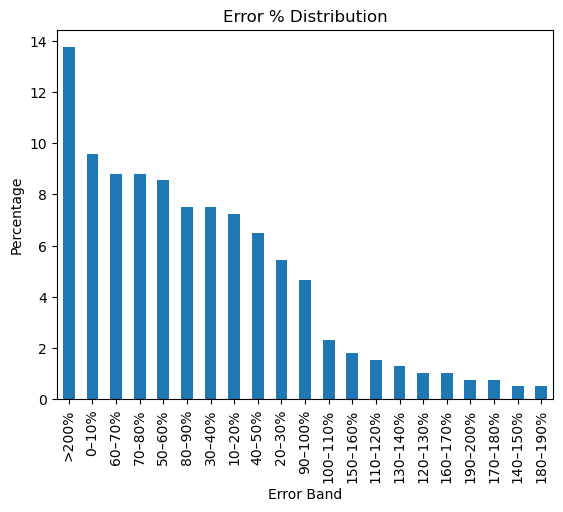

In [298]:
error_perc = results['Error Band'].value_counts(normalize=True) * 100

error_perc.plot(kind='bar', title='Error % Distribution',
               ylabel='Percentage');

# Notes

## * I seem to have over simplified the Vertical column in my reclassification, seeing that performance dropped when introducing the engineered column.
## * My suspicion is that I may have done the same in some SubVertical (like Food, Finance and Education), and I may be able to recover signal by loosening them a bit.
## * Best Model so far has been able to do predictions with a .2 - 3% error range, which Im extremely happy with.
## * Best Model´s worst errors come from outliers, I will either cut them or train a separate model just for them.